# Réseaux neuronaux convolutifs, Convolutional Neural Networks, CNN


In [1]:
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms

# %matplotlib inline

# Introduction : faire une convolution 2-d de base sur Pytorch

Télécharger et ouvrir une image

In [2]:
!wget -q https://www.irit.fr/~Thomas.Pellegrini/ens/M2RFA/mire.png


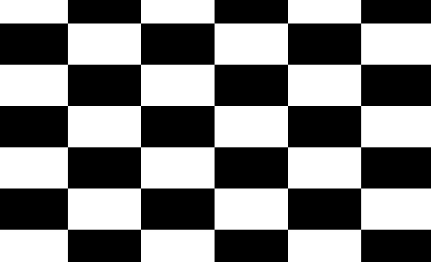

In [3]:
from PIL import Image

img = Image.open("mire.png")
img


Transformer l'image object de type PIL en un tensor pytorch. Quelles sont les dimensions de ce tenseur ? Expliquer chacune des dimensions.

In [4]:
transform = transforms.ToTensor()
x = transform(img)
x.size()

torch.Size([4, 262, 431])

Prendre la moyenne du tenseur sur la dimension des canaux, en utilisant ```torch.mean()``` ou bien ```x.mean()```. 

Remarque : l'option ```keepdim=True``` permet de garder le nombre de dimensions intact.

Utiliser la fonction `unsqueeze` ou `unsqueeze_` pour obtenir un tenseur à 4 dimensions :

B=1 x C=1 x W x H

In [ ]:
x = ???

x.size(), type(x)

Réaliser une convolution 2d sur le tenseur avec un filtre (un "kernel") de taille `3 x 3` qui détecte les bords verticaux. Le kernel doit contenir les valeurs suivantes (cf cours) : 

  \begin{pmatrix}
  -1 & 0 & 1 \\
  -1 & 0 & 1 \\
  -1 & 0 & 1 \\
  \end{pmatrix}


Pour cela utiliser la fonction `conv2d` de `torch.nn.functional`, *i.e.* `F.conv2d` :

https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html

__Attention aux dimensions attendues pour ce kernel ! Bien lire la doc__

In [ ]:
filtre = torch.tensor(???, dtype=torch.float32)
print(filtre.size())
out = F.conv2d(??)
out.size()

Si votre résultat s'appelle par exemple out, vous pouvez l'afficher sous forme d'image ainsi :

In [ ]:
im = transforms.ToPILImage()(out.squeeze(0)) 
display(im)

Réfaire l'opération de convolution mais cette fois-ci pour détecter les bords __horizontaux__. 

Vous pouvez utiliser l'opérateur `permute()`, qui prend toutes les dimensions du tenseur en argument (ici le tenseur du filtre) pour les échanger.

Exemple : 

Soit un tenseur `t` de dimension 10x30x5.

Pour inverser la première et la dernière dimension, il faut faire : `t = t.permute(2,1,0)`

In [ ]:
filtre2 = ??
out = F.conv2d(??)
im = transforms.ToPILImage()(out.squeeze(0)) 
display(im)

# Partie II : CNN et MLP sur MNIST

## Data : MNIST


Le jeu de données MNIST contient des chiffres manuscrits (numériques) en noir et blanc, de taille 28x28 pixels.

Nous n'utiliserons que les 2500 premières images : 2000 pour le train et les 500 suivantes en validation.

La première fois que cette cell est utilisée, MNIST est téléchargé.

In [ ]:
mnist_train = datasets.MNIST('data',
                             train=True,
                             download=True,
                             transform=transforms.ToTensor())
mnist_train = list(mnist_train)[:2500]

mnist_train, mnist_val = mnist_train[:2000], mnist_train[2000:]

## Modèles

Nous allons travailler avec deux modèles : un MLP et un réseau neuronal convolutif (CNN).


Pour définir un réseau il faut déclarer une classe qui hérite de `nn.Module` et qui possède deux méthodes :



*   `__init__(self, arguments)`
*   `forward(self, arguments)` qui réalise une passe forward à l'aide des couches déclarées dans `__init__` et de fonctionnelles du module `F`

Ainsi lorsque l'on définit un CNN, on va déclarer des couches de convolution qui sont des *modules*, à l'aide de `nn.Conv2d` et non la fonction `F.conv2d` qui est une fonctionnelle. Vous remarquerez l'usage d'une majuscule dans `nn.Conv2d`.



In [ ]:
# Perceptron multi-couche 
class MLP(nn.Module):
    def __init__(self, num_hidden):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(28 * 28, num_hidden)
        self.layer2 = nn.Linear(num_hidden, 10)
        self.num_hidden = num_hidden
    def forward(self, img):
        flattened = img.view(-1, 28 * 28) # flatten the image
        activation1 = self.layer1(flattened)
        activation1 = torch.relu(activation1)
        activation2 = self.layer2(activation1)
        return activation2


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=2,
                               kernel_size=5)        
        # pour info, on pourrait plus simplement écrire :
        # self.conv1 = nn.Conv2d(1, 10, kernel_size=5, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=2,
                               out_channels=4,
                               kernel_size=5)
        self.fc = nn.Linear(4 * 4 * 4, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 4 * 4 * 4)
        return self.fc(x)

Une façon d'évaluer la "complexité" ou la "capacité" d'un réseau
est de regarder le nombre de paramètres :

In [ ]:
def print_num_parameters(model):
    print("Nombre de paramètres :",
          sum(p.numel() for p in model.parameters()))

print_num_parameters(CNN())

## Apprentissage

On définit une fonction train qui s'occupe d'entraîner le modèle sur les données de train et qui mesure la loss sur le train, sur valid et les accuracies de "temps en temps", toutes les 50 itérations ici : 

In [ ]:
def train(model, data, batch_size=64, weight_decay=0.0,
          optimizer="sgd", learning_rate=0.1, momentum=0.9,
          data_shuffle=True, num_epochs=10):
    # les données de train : un DataLoader qui fournit des minibatchs
    train_loader = torch.utils.data.DataLoader(data,
                                               batch_size=batch_size,
                                               shuffle=data_shuffle)
    # la loss 
    criterion = nn.CrossEntropyLoss()
    # l'optimiseur
    assert optimizer in ("sgd", "adam")
    if optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(),
                              lr=learning_rate,
                              momentum=momentum,
                              weight_decay=weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(),
                               lr=learning_rate,
                               weight_decay=weight_decay)
    # on track la learning curve avec des listes
    iters, iters_acc, losses, train_acc, val_acc = [], [], [], [], []
    # training
    n = 0 # nombre d'iterations (pour faire des figures)
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            if imgs.size()[0] < batch_size:
                continue

            model.train() # met le modèle en mode train
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss

            if n % 50 == 0 :
              train_acc.append(get_accuracy(model, train=True)) # compute training accuracy 
              val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
              iters_acc.append(n)

            n += 1

    # plotting
    plt.title("Courbe d'apprentissage")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Courbe d'apprentissage")
    plt.plot(iters_acc, train_acc, label="Train")
    plt.plot(iters_acc, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Précision finale Train : {}".format(train_acc[-1]))
    print("Précision finale Valid : {}".format(val_acc[-1]))

Nous avons également besoin d'une fonction qui calcule la précision ou *accuracy*. 

Pour transformer les probabilités en une prédiction discrète, nous prendrons l'indice de la classe avec la probabilité la plus élevée.

En raison de la façon dont softmax est calculée, cet indice 
est le même que celui pour lequel la pré-activation est la plus élevée.

In [ ]:
def get_accuracy(model, train=False):
    if train:
        data = torch.utils.data.DataLoader(mnist_train, batch_size=256)
    else:
        data = torch.utils.data.DataLoader(mnist_val, batch_size=256)

    model.eval() # met le modèle en mode test (inhibe le dropout par exemple)
    correct = 0
    total = 0
    for imgs, labels in data:
        output = model(imgs) # pas besoin de torch.softmax
        pred = output.max(1, keepdim=True)[1] # retrouve l'indice de la log-proba maximale
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

Testons sur le CNN :

In [ ]:
model = CNN()
train(model, mnist_train, batch_size=64, optimizer="sgd", learning_rate=0.1,
      momentum=0., num_epochs=10)

### Rôle du shuffle

Et si on désactive le `data_shuffle` ? C'est-à-dire, que se passe-t-il si nous utilisons les **mêmes mini-batchs** à travers toutes les epochs ? Pouvez-vous expliquer ce qui se passe dans les courbes d'apprentissage ?

In [ ]:
model = CNN()
train(model, mnist_train, learning_rate=0.1, data_shuffle=False)

# Expériences avec le MLP

Nous allons faire des expériences avec un MLP plutôt qu'avec le CNN car il est beaucoup plus rapide à entraîner (même sur CPU ici, car c'est un petit modèle).

Définissons un MLP avec une couche cachée de 50 neurones :

In [ ]:
model = MLP(50)

Combien de paramètres contient-il ?

In [ ]:
print_num_parameters(model)

Faisons un premier apprentissage, similaire au CNN : 

In [ ]:
train(model, mnist_train, learning_rate=0.1)

## Momentum

Nous allons principalement expérimenter avec le modèle `MLP(30)`, car c'est celui qui s'entraîne le plus rapidement.

Nous mesurerons la rapidité de l'apprentissage du modèle en regardant les progrès réalisés dans les 3 premières épochs d'apprentissage. 

Quels résultats obtient-on sans utiliser momentum, avec un taux d'apprentissage de 0.1 ?

In [ ]:
model = MLP(30)
train(model, mnist_train, learning_rate=0.1, momentum=0., num_epochs=3)

Avec un taux d'apprentissage et un momentum bien réglés, l'apprentissage peut aller plus vite.

Remarque : nous avons dû essayer plusieurs paramètres avant d'en trouver un qui fonctionne bien. Nous vous encourageons à essayer différentes combinaisons de taux d'apprentissage et de momentum. Par exemple prendre un taux d'apprentissage de 0.1 et un momentum de 0.5 %.

In [ ]:
model = MLP(30)
train(model, mnist_train, learning_rate=0.05, momentum=0.9, num_epochs=3)

L'optimiseur Adam fonctionne bien et est d'ailleurs l'optimiseur le plus populaire actuellement.

Adam requiert généralement un taux d'apprentissage plus faible : commencer par 0,001, puis augmenter/diminuer comme bon vous semble. Ici, 0.005 fonctionne bien.

In [ ]:
model = MLP(30)
train(model, mnist_train, optimizer="adam", learning_rate=0.005, num_epochs=3)

## Batch Normalization (petit nom : batchnorm)

Batch normalization peut beaucoup accélérer (et stabiliser) l'apprentissage !

In [ ]:
class MLPBN(nn.Module):
    def __init__(self, num_hidden):
        super(MLPBN, self).__init__()
        self.layer1 = nn.Linear(28 * 28, num_hidden)
        self.bn = nn.BatchNorm1d(num_hidden)
        self.layer2 = nn.Linear(num_hidden, 10)
        self.num_hidden = num_hidden
    def forward(self, img):
        flattened = img.view(-1, 28 * 28) # flatten 
        activation1 = self.layer1(flattened)
        activation1 = torch.relu(activation1)
        activation1 = self.bn(activation1)
        activation2 = self.layer2(activation1)
        return activation2

mlp_bn = MLPBN(30)
train(mlp_bn, mnist_train, optimizer="adam", learning_rate=0.005, num_epochs=3)

Il y a un débat pour savoir si la batch-norm doit être appliquée
*avant* ou *après* l'activation. L'article original 
appliquait la normalisation avant l'activation de ReLU, mais l'application de la normalisation *après* la ReLU donne de meilleurs résultats dans la pratique. 

La raison pourrait être la suivante :

1. Si nous appliquons la normalisation avant la ReLU, alors nous ignorons effectivement les biais des neurones, puisque les activations vont être centrées.

2. Si nous appliquons la normalisation après ReLU, nous aurons des informations 
   positives et négatives qui seront transmises à la couche suivante.


In [ ]:
class MLPBNBeforeReLu(nn.Module):
    def __init__(self, num_hidden):
        super(MLPBNBeforeReLu, self).__init__()
        self.layer1 = nn.Linear(28 * 28, num_hidden)
        self.bn = nn.BatchNorm1d(num_hidden)
        self.layer2 = nn.Linear(num_hidden, 10)
        self.num_hidden = num_hidden
    def forward(self, img):
        flattened = img.view(-1, 28 * 28) # flatten 
        activation1 = self.layer1(flattened)
        activation1 = self.bn(activation1)
        activation1 = torch.relu(activation1)
        activation2 = self.layer2(activation1)
        return activation2
    
train(MLPBNBeforeReLu(30), mnist_train, optimizer="adam", learning_rate=0.005, num_epochs=3)

Batch norm est utilisée aussi dans les CNN.

In [ ]:
class CNNBN(nn.Module):
    def __init__(self):
        super(CNNBN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=4,
                               kernel_size=3,
                               padding=1)
        self.bn1 = nn.BatchNorm2d(4) # nb de channels out
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=4,
                               out_channels=8,
                               kernel_size=3,
                               padding=1)
        self.bn2 = nn.BatchNorm2d(8) # nb de channels out
        self.fc = nn.Linear(8 * 7 * 7, 10)
    def forward(self, x):
        x = self.bn1(torch.relu(self.conv1(x)))
        x = self.pool(x)
        x = self.bn2(torch.relu(self.conv2(x)))
        x = self.pool(x)
        x = x.view(-1, 8 * 7 * 7)
        return self.fc(x)

train(CNNBN(), mnist_train, optimizer="adam", learning_rate=0.005, num_epochs=3)

## Initialisation des poids à zéro : pas une bonne idée...

Si nous initialisons les poids à zéro, le réseau sera coincé dans un point "selle" (*saddle point*). 

Étant donné que nous utilisons la descente de gradient stochastique, nous ne verrons que du bruit dans les courbes d'apprentissage et surtout aucun progrès.

In [ ]:
model = MLP(30)
for p in model.parameters():
    nn.init.zeros_(p)
train(model, mnist_train, optimizer="adam", learning_rate=0.005, num_epochs=3)

# Un "vrai" réseau LeNet5

Récupérer l'article LeNet5 sur moodle, implanter le réseau décrit dans l'article. Tester-le sur les données complètes MNIST. Peut-être activer le GPU de ce notebook si l'entraînement est trop long...